CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.05MB/s]


CODE BLOCK: 5

In [5]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

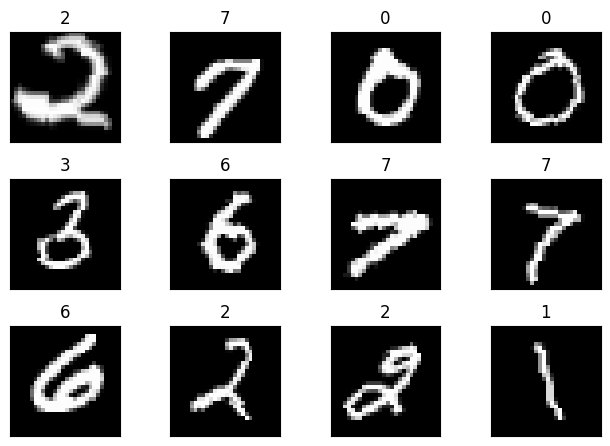

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input: 1 channel x 28 height x 28 width.
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)    # output -> 8x28x28, parameters here -> 1*8*3*3=72, parameters_total -> 72
        # 1 → number of input channels (MNIST is grayscale → 1 channel)
        # 8 → number of output channels (this layer produces 8 feature maps)
        # 3 → kernel size (3x3 filter)
        # padding=1 → pads the input with 1 pixel on all sides → keeps output size same as input
        # parameter count = in_channel x out_channel x kernel_height x kernel_width

        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)   # output -> 16x28x28, paramters here -> 8*16*3*3=1152, parameters_total -> 1152+72=1224
        self.pool = nn.MaxPool2d(2, 2)                # output -> 16x14x14, paramters here -> no effect, parameters_total -> no effect
        # (kernel_size, stride)
        # MaxPool reduces H and W by 2 (stride=2)
        # Output shape: 16 × 14 × 14
        # Parameters: 0 (pooling has no learnable parameters)

        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)  # -> 16x14x14 paramters here -> 16*16*3*3, parameters_total -> 2304+1224=3528
        self.conv4 = nn.Conv2d(16, 32, 3, padding=1)  # -> 32x14x14 paramters here -> 16*32*3*3, parameters_total -> 4608+3528=8136
        self.pool2 = nn.MaxPool2d(2, 2)               # -> 32x7x7 no effect, only dimension decreases

        self.fc1 = nn.Linear(32*7*7, 10)              # -> paramters here -> 32*7*7*10=15680, parameters_total -> 15680+8136=23816

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


CODE BLOCK: 8

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [9]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

def GetCorrectPredCount(pPrediction, pLabels):
    """
    pPrediction: Tensor of shape [batch_size, num_classes]
        Example: [[2.5, 0.3, -1.0],   # sample 1 logits
                  [-1.0, 0.3, 2.5]]   # sample 2 logits

    pLabels: Tensor of shape [batch_size]
        Example: [0, 2]   # true labels (class indices)

    Process:
      1. pPrediction.argmax(dim=1) → picks class with max logit per sample
         Example: [0, 2]
      2. Compare with pLabels → [True, True]
      3. Sum → number of correct predictions (2 in this case)

    Returns:
      Integer: number of correct predictions in this batch
    """
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
    model.train()  # Enable training mode (dropout/batchnorm active)
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        """
        batch_idx: integer, index of the current batch (0, 1, 2, ...)
        data: tensor of shape [batch_size, channels, height, width]
              Example: [64, 1, 28, 28] for MNIST batch of 64 images
              data[0] = first image in batch, shape [1,28,28]
        target: tensor of shape [batch_size]
                Example: [5, 0, 3, ...] labels for each image in the batch
        This line fetches a **single batch** from the DataLoader each iteration.
        """

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # Reset gradients from previous step

        # 1️⃣ Forward pass: model transforms input → logits
        # Internal call: model(data) → triggers model.forward(data)
        pred = model(data)
        # Example shapes:
        # data: [2,1,28,28], pred: [2,10] (2 images, 10 classes)
        # Each row in pred = raw scores (logits) for each class

        # 2️⃣ Compute loss
        # criterion = nn.CrossEntropyLoss()
        # Internally:
        #    - softmax(pred) → probabilities
        #    - negative log likelihood of true class
        # Example:
        # pred[0] = [2.5, 0.3, -1.0, ...] (logits)
        # target[0] = 0
        # -log(softmax(pred[0])[0]) = contribution to loss check about softmax here: https://www.notion.so/Vision-a80ad2dc4f88489bb3ecc45eac005ea2?source=copy_link#2692ba0a615b808b87a1d7d9d5d0da0c
        loss = criterion(pred, target)
        train_loss += loss.item()  # accumulate scalar loss

        # 3️⃣ Backward pass: compute gradients
        loss.backward()

        # 4️⃣ Optimizer step: update weights
        optimizer.step()

        # 5️⃣ Track training accuracy
        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        # Update progress bar
        pbar.set_description(desc=f'Train: Loss={loss.item():0.4f} '
                                   f'Batch_id={batch_idx} '
                                   f'Accuracy={100*correct/processed:0.2f}')

    # Store epoch-level metrics
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()  # Evaluation mode (dropout/batchnorm frozen)

    test_loss = 0
    correct = 0

    with torch.no_grad():  # Disable gradient computation
        for batch_idx, (data, target) in enumerate(test_loader):
            """
            Forward pass only (no backward):
              - Compute output logits for the batch
              - Do not compute gradients (no memory overhead)
            batch_idx: index of batch
            data: [batch_size, channels, height, width]
            target: [batch_size] true labels
            """

            data, target = data.to(device), target.to(device)

            # 1️⃣ Forward pass only (no weight updates)
            output = model(data)
            # output shape: [batch_size, num_classes]
            # Each row = logits for that image

            # 2️⃣ Compute batch loss
            test_loss += criterion(output, target).item()

            # 3️⃣ Count correct predictions
            correct += GetCorrectPredCount(output, target)

    # Average test loss across all samples
    test_loss /= len(test_loader.dataset)

    # Test accuracy
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [10]:
device = 'cuda'
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
criterion = nn.CrossEntropyLoss()
num_epochs = 1

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.0619 Batch_id=117 Accuracy=89.53: 100%|██████████| 118/118 [00:21<00:00,  5.59it/s]


Test set: Average loss: 0.0001, Accuracy: 9781/10000 (97.81%)



In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
            Conv2d-2           [-1, 16, 28, 28]           1,168
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           2,320
            Conv2d-5           [-1, 32, 14, 14]           4,640
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                   [-1, 10]          15,690
Total params: 23,898
Trainable params: 23,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.09
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

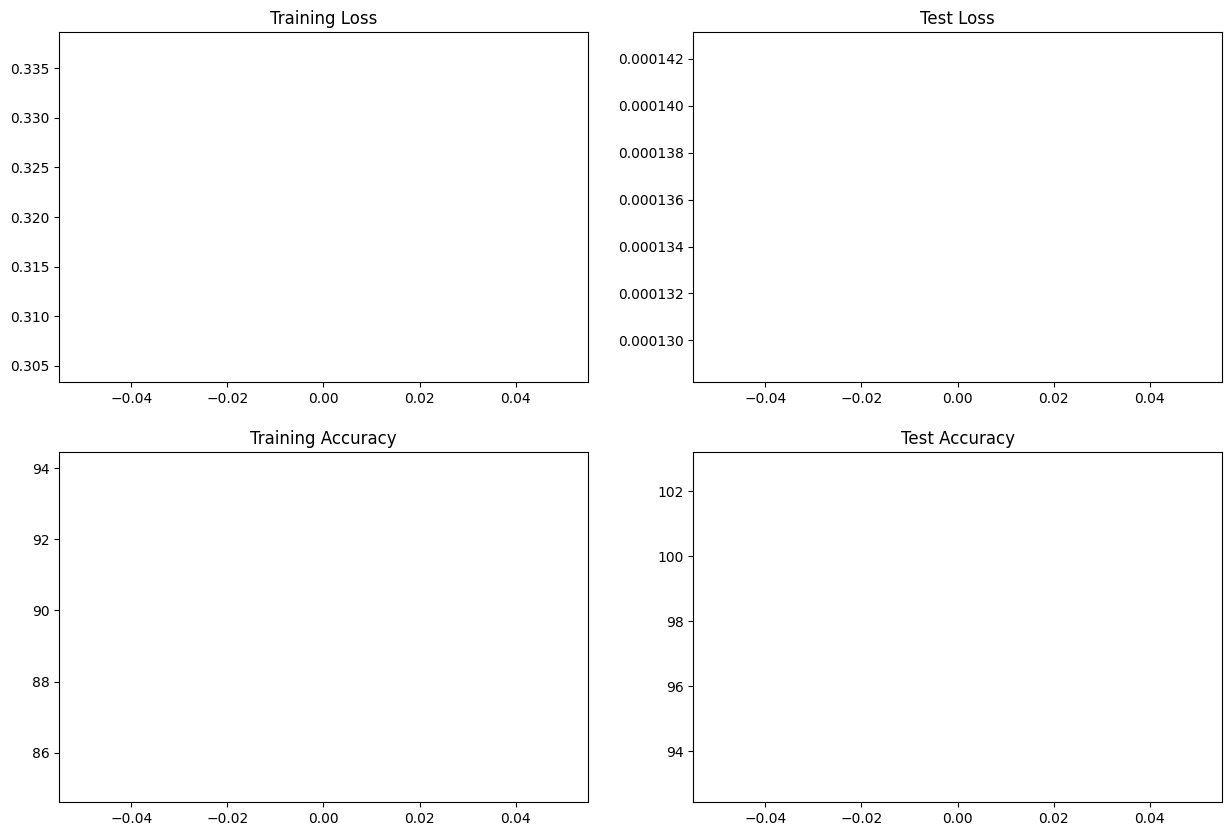

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [13]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
            Conv2d-2           [-1, 16, 28, 28]           1,168
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           2,320
            Conv2d-5           [-1, 32, 14, 14]           4,640
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                   [-1, 10]          15,690
Total params: 23,898
Trainable params: 23,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.09
Estimated Total Size (MB): 0.35
----------------------------------------------------------------
